## Installments and Imports

In [65]:
# Adapted from nutritional_adequacy lecture
!pip install -r requirements.txt
!pip install eep153_tools

import cfe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [66]:
#Load data
quant = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='Quantities')
hh = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='HH Characteristics')
expend = pd.read_excel('Bukidnon 2003.xlsx',sheet_name ='Expenditures')
nut = pd.read_excel('Bukidnon 2003.xlsx',sheet_name='FCT')

In [67]:
# Load results
r = cfe.result.from_dataset('BUK.ds',engine='netcdf4')

# Reference period, market
t,m = 2003, 'Bukidnon'

# Reference budget (find mean in reference period & market):
reference_x = r.get_predicted_expenditures().mean('j').sum('i').sel(m=m)  


p = r.prices.sel(m=m,drop=True)
p = p.to_dataframe('i').squeeze().dropna()
p = p.xs(2003.,level='variable')
p

#with this notebook we are looking at min of nutrients per household
#allows getting rid of different units for measuring and think ab ratio instead

i
Bagoong                          0.037190
Banana                           0.021401
Beef                             0.135031
Carrots                          0.027822
Chicken                          0.097764
Coffee                           0.732034
Cooking oil                      0.038578
Eggs                             0.092641
Food made from flour             0.016472
Fresh fish                       0.046502
Mangoes                          0.045497
Milk                             0.277523
Milo                             0.217887
Mongo and other products         0.038700
Onions                           0.043971
Peanut                           0.170558
Pork                             0.102934
Potato                           0.028599
Processed meat like longanisa    0.144143
Rice                             0.021202
Salt                             0.015549
Sardines                         0.078127
Sea weed                         0.035359
Soybean and other products      

## Filtering data by household characteristics

In [68]:
# 2 or more women of childbearing age (potential mothers)
pm_hh = hh[hh[['Females 15-20','Females 20-30']].sum(axis=1) > 2]

# Large household, lots of kids
ch_hh = pm_hh[pm_hh['log HSize'] > 2]
ch_j = ch_hh['j']
r = r.sel(j=ch_j)

r

<xarray.Result>
Dimensions:           (i: 29, k: 19, variable: 1, m: 1, j: 52, t: 1, kp: 19)
Coordinates:
  * i                 (i) object 'Bagoong' 'Banana' ... 'Talong' 'Tomatoes'
  * k                 (k) object 'Males 0-1' 'Males 1-5' ... 'log HSize'
  * variable          (variable) float64 2.003e+03
  * m                 (m) object 'Bukidnon'
  * j                 (j) float64 106.0 115.0 123.0 144.0 ... 775.0 785.0 88.0
  * t                 (t) float64 2.003e+03
  * kp                (kp) object 'Males 0-1' 'Males 1-5' ... 'log HSize'
Data variables: (12/20)
    alpha             float64 nan
    beta              (i) float64 0.2534 0.5821 0.4597 ... 0.2713 0.5006 0.4771
    delta             (k, i) float64 -0.05259 0.2786 0.245 ... -0.4271 -0.4551
    prices            (variable, i, m) float64 0.03719 0.0214 ... 0.02372
    characteristics   (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 2.079 2.773 2.303
    loglambdas        (j, t, m) float64 0.3338 -0.6932 ... 0.7803 0.09709
    ...                ...
    se_beta           float64 nan
    se_alpha          float64 nan
    se_a              (i, t, m) float64 0.03899 0.05199 ... 0.05059 0.04981
    y                 (i, j, t, m) float64 2.015 2.708 1.504 ... nan 2.303 1.099
    logp              (variable, i, m) float64 -3.292 -3.844 ... -4.168 -3.741
    z                 (k, j, t, m) float64 0.0 0.0 0.0 0.0 ... 2.079 2.773 2.303
Attributes:
    firstround:            2003.0
    min_proportion_items:  0.125
    min_xproducts:         30
    all_tm:                True
    common_alpha:          True
    useless_expenditures:  False
    stderr_tol:            0.01
    indices:               Indices(j='j', t='t', m='m', i='i', k='k')
    iterate:               False
    verbose:               False

## Nutritional requirements



### Nutritional Needs of Households

In [69]:
# In first round, averaged over households and villages

zbar = r.z.sel(t=r.firstround,drop=True).mean(['j','m'])[:-1].squeeze() # Leave out log HSize

zbar = zbar.to_dataframe().squeeze()
zbar

k
Males 0-1         0.134615
Males 1-5         0.173077
Males 5-10        0.250000
Males 10-15       0.634615
Males 15-20       0.480769
Males 20-30       1.423077
Males 30-50       1.057692
Males 50-60       0.519231
Males 60-100      0.269231
Females 0-1       0.019231
Females 1-5       0.384615
Females 5-10      0.403846
Females 10-15     0.365385
Females 15-20     1.000000
Females 20-30     2.403846
Females 30-50     1.307692
Females 50-60     0.442308
Females 60-100    0.211538
Name: z, dtype: float64

In [70]:
# Compute the minimum requirements for the average household:

rda = pd.read_csv('diet_minimums.csv').set_index('Nutrition').iloc[:,2:]

# Focus only on children and mothers
zbar['Boys'] = zbar['Males 5-10']*5/15 + zbar['Males 10-15']*5/15 + zbar['Males 15-20'] * 5/15
zbar['Girls'] = zbar['Females 5-10']*5/15 + zbar['Females 10-15']*5/15 + zbar ['Females 15-20'] * 5/15
zbar['Mothers'] = zbar['Females 15-20']*5/15 + zbar['Females 20-30']*10/15

rda['Boys'] = rda['M 4-8']*4/16 + rda['M 9-13']*5/16 + rda['M 14-18']*5/16 + rda['M 19-30']*2/16
rda['Girls'] = rda['F 4-8']*4/16 + rda['F 9-13']*5/16 + rda['F 14-18']*5/16 + rda['F 19-30']*2/16
rda['Mothers'] = rda['F 14-18']*4/16 + rda['F 19-30']*12/16

zbar = zbar[['Boys', 'Girls', 'Mothers']]
rda = rda[['Boys', 'Girls', 'Mothers']]
# May need to tweak types or alignment to match RDA and zbar types:
rda0,zbar0=rda.align(zbar,axis=1)
# This matrix product gives minimum nutrient requirements for average household in Bukidnon, 2003
hh_rda = rda0.replace('',0)@zbar0
# RDA is /daily/, but  demands in BUK data are /weekly/:
hh_rda = hh_rda*7
hh_rda

Nutrition
Energy                            39134.935897
Protein                             892.965545
Fiber, total dietary                547.889103
Folate, DFE                        7751.883013
Calcium, Ca                       23253.125000
Carbohydrate, by difference        2712.500000
Iron, Fe                            313.106971
Magnesium, Mg                      6348.433494
Niacin                              279.360577
Phosphorus, P                     18617.588141
Potassium, K                      95964.503205
Riboflavin                           21.391506
Thiamin                              21.252123
Vitamin A, RAE                    14107.411859
Vitamin B-12                         46.511298
Vitamin B-6                          24.691546
Vitamin C, total ascorbic acid     1364.102564
Vitamin E (alpha-tocopherol)        289.209936
Vitamin K (phylloquinone)          1672.161458
Zinc, Zn                            170.296875
dtype: float64

## Nutritional Adequacy of Food Demands



### Food Conversion Table



In [71]:
UseNutrients=['calorie','protein','calcium','carbo','iron']

In [72]:
from eep153_tools.sheets import read_sheets

# Use the food conversion table
fct = nut.iloc[:,3:]
fct['i'] = fct['name']
fct = fct.set_index('i').iloc[:,1:]

# Select only desired nutrients from the fct table
fct = fct[UseNutrients]

# Rename and select desired nutrients from the hh_rda series
hh_rda = hh_rda[['Energy','Protein','Calcium, Ca','Carbohydrate, by difference','Iron, Fe']]
hh_rda = hh_rda.rename({'Energy':'calorie','Protein':'protein','Calcium, Ca':'calcium',
                        'Carbohydrate, by difference':'carbo','Iron, Fe':'iron'})
hh_rda

Nutrition
calorie    39134.935897
protein      892.965545
calcium    23253.125000
carbo       2712.500000
iron         313.106971
dtype: float64

In [73]:
# Discover the top 20 foods with the highest calcium
calc = fct['calcium'].sort_values(ascending=False).head(20)
px.bar(calc/calc[0])

In [74]:
# Discover the top 20 foods with the highest iron
iron = fct['iron'].sort_values(ascending=False).head(20)
px.bar(iron/iron[0])

In [75]:
# Discover the top 20 foods with the highest protein
prot = fct['protein'].sort_values(ascending=False).head(20)
px.bar(prot/prot[0])

In [76]:
# Discover the top 20 foods with the highest carbs
carb = fct['carbo'].sort_values(ascending=False).head(20)
px.bar(carb/carb[0])

In [77]:
# Discover the top 20 foods with the highest calories
cal = fct['calorie'].sort_values(ascending=False).head(20)
px.bar(cal/cal[0])

### Prices



In [78]:
def my_prices(p0,p=p,i='Coconut'):
    p = p.copy()
    p.loc[i] = p0
    return p

### Nutrient Demand



In [79]:
# We can also use our demand functions to
#  compute nutrition as a *function* of prices and budget.

import warnings 

def nutrient_demand(x,p):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    c = r.demands(x,p)    
    
    fct0,c0 = fct.align(c,axis=0,join='inner')
    
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

Text(0, 0.5, 'log nutrient')

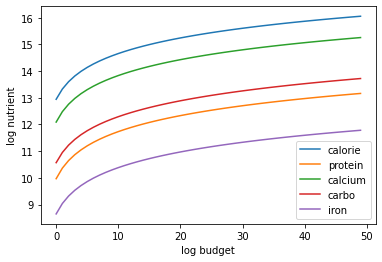

In [80]:
# With this `nutrient_demand` function in hand, we can see how nutrient
#  outcomes vary with budget, given prices:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(reference_x/5,reference_x*5,50)

df = pd.concat([np.log(nutrient_demand(myx,p))[UseNutrients] for myx in X],axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Text(0.5, 1.0, 'Sea weed')

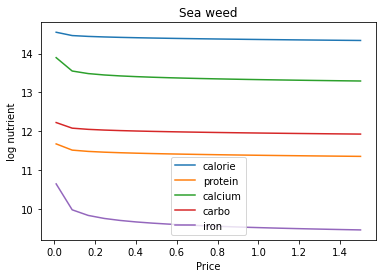

In [81]:
# Now how does nutrition vary with prices?
# Here we trace out nutritional adequacy varying the price of a single good

USE_GOOD = 'Sea weed' 

P = np.linspace(.01,1.5,20).tolist()

ndf = pd.DataFrame({p0:np.log(nutrient_demand(reference_x,my_prices(p0,i=USE_GOOD)))[UseNutrients] for p0 in P}).T
ax = ndf.plot()

ax.set_xlabel('Price')
ax.set_ylabel('log nutrient')
ax.set_title(USE_GOOD)

### Nutritional Adequacy



In [82]:
# normalize nutritional intake to check the adequacy of diet.

def nutrient_adequacy_ratio(x,p):
    return nutrient_demand(x,p)/hh_rda

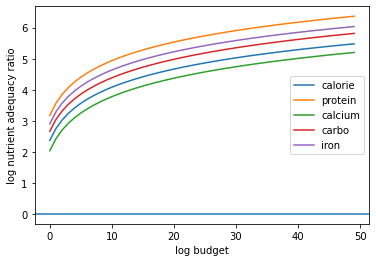

In [83]:
# Here we trace out nutritional adequacy varying the budget

X = np.linspace(reference_x/5,reference_x*5,50)

ndf = pd.concat([np.log(nutrient_adequacy_ratio(x,p))[UseNutrients] for x in X],axis=1).T

ax = ndf.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient adequacy ratio')
ax.axhline(0)

Text(0.5, 1.0, 'Sea weed')

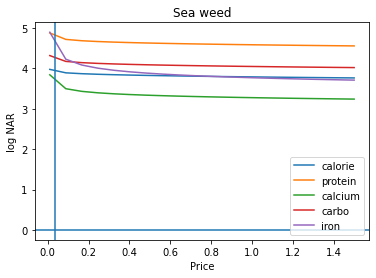

In [84]:
USE_GOOD = 'Sea weed'

poorer_x = reference_x/2

Pscale = np.linspace(0.01,1.5,20).tolist()

log_nar = {s0:np.log(nutrient_adequacy_ratio(reference_x,my_prices(s0,p,i=USE_GOOD)))[UseNutrients] 
           for s0 in Pscale}

log_nar = pd.DataFrame(log_nar).T

ax = log_nar.plot(ylabel='log NAR',xlabel='Price')


ax.axhline(0)
ax.axvline(p[USE_GOOD])
ax.set_title(USE_GOOD)